# Log
- optimization averege across different confusion matrices - that seems to have a big effect on the performance of enabling surrogate

# TODO
 - keep the confusion matrix estimation same - across all trials?
 - double check that params are getting properly propagated for the Agent and environment
 - ~~grid search for parameters~~
 - figure out parameters in surrogate rewards
 - ~~make rewards non binary in environment and surrogate rewards~~
 - ~~add deceay from papers, log and other~~
 - ~~initiate q-table at `-1`?~~
 - run experiment with different `correct_action`
 - should we be setting up the glove for `very distinguishable` levels? Shouldn't we set it up with `barely distinguishable` levels, as this is where the perturbed rewards come on - they'd help us get through the noise and find the correct level.

# Imports

In [1]:
import collections
import pandas as pd
import argparse
import time
import numpy as np

In [2]:
import noise_estimator

In [3]:
from ucbq_agent_stateless import UCBQAgent
from ucbq_environment_stateless import ModifiedRandomEnvironment

In [4]:
import matplotlib.pyplot as plt
from tqdm import tqdm 
import utils

from modified_pendulum_processor import ModifiedPendulumProcessor

from utils import *

# Params

In [5]:
def default_params():
    """ These are the default parameters used in the framework. """
    return {
            # Runner parameterr
            'max_steps': 120,
            'num_episodes': 100,
            'num_actions': 7, 
            'start_action': 0, 
            'correct_action': 1,    # Zero indexed 
            # Optimization parameters
            'alpha': 0.5,                       # learning rate of optimizer
            'alpha_decay': 40,
            'alpha_min': 0.001,
            # Exploration parameters
            'epsilon': 1,               # annealing starts at this epsilon
            'epsilon_decay': 20,
            'epsilon_min': 0.01,    
            'gamma': 0.95,                    # discount factor gamma
            'plots': False,
            'noise': True,
            'surrogate': False,
            'surrogate_c_interval': 10,
            'surrogate_c_interval_min': 30,
           }

# Noiseless rewards UCB Q-learning

Q-table:
[[-7  0 -7 -7 -6 -6 -5]]
Number of times action was taken:
[[ 5. 30.  5.  6.  2.  2.  6.]]
Total timesteps:
50


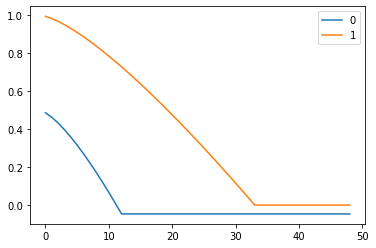

In [6]:
params_new ={
    'noise': False,
    'alpha_decay': 20,
    'epsilon_decay': 40,
    }
params = default_params() | params_new

agent = UCBQAgent(params=params)

q_values_for_chart, rewards, episode_length, selected_action, reward_processor, alphas, epsilons = runner(agent=agent, params=params)
utils.print_agent_stats(agent)
pd.DataFrame([alphas, epsilons]).T.plot()

100%|██████████| 100/100 [00:00<00:00, 635.85it/s]


Accuracy: 100.0
Mean episode length: 50.0


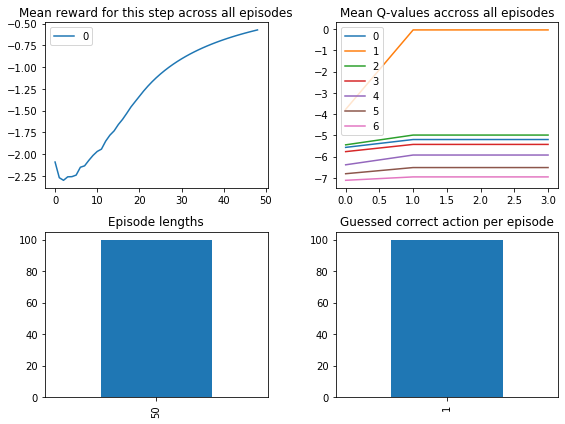

In [7]:
params = default_params()
params['noise'] = False
params['plots'] = True

# The Q-value shape make sense - we're trying higher numbers later
# so they converge to -1 slower than e.g. action 0 or 1
plot_mean_q_values(params=params)

# Noisy rewards
- rewards are now noisy
- q-learner hasn't changed

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay

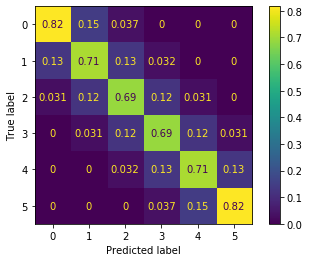

True

In [9]:
params = default_params()
num_actions = params['num_actions']
correct_action = params['correct_action']
params['diag'] = 0.69
# Confusion matrix used as noise
num_unique_rewards = utils.get_num_unique_rewards(num_actions=num_actions, correct_action=correct_action)
cmat = ModifiedPendulumProcessor(num_unique_rewards=num_unique_rewards).initialize_cmat(diag=params['diag'])
ConfusionMatrixDisplay(confusion_matrix=cmat).plot()
plt.show()
noise_estimator.is_invertible(cmat)

100%|██████████| 100/100 [00:00<00:00, 487.46it/s]


Accuracy: 66.0
Mean episode length: 50.0
Last reward processor:
Estimated confusion matrix:


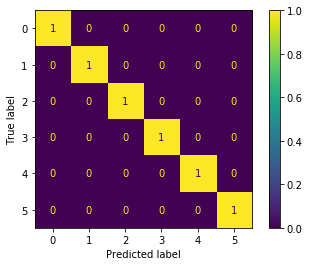

Reward sets:
(0, 1): [0]
(0, 2): [-1, -2, 0, 0, 0, 0, -1, -2, 0, -1, 0, -1, -2, -1, -1, -1, -2, -2, -1, -1, 0, -1, 0, -1, -1, -1, 0, -1, -1, -1, -1, -2, -2, 0, 0, -1, -2, -2]
(0, 3): [-2]
(0, 4): [-2, -3, -3, -2, -3]
(0, 5): [-5]
(0, 6): [-5, -5, -5]
Reward set counts:
Key (0, 1): 1 items
Key (0, 2): 38 items
Key (0, 3): 1 items
Key (0, 4): 5 items
Key (0, 5): 1 items
Key (0, 6): 3 items


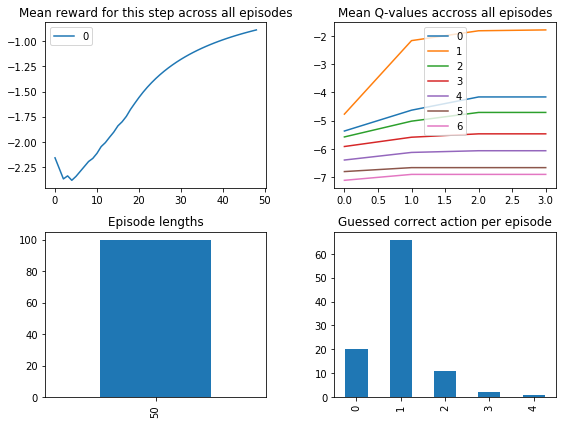

In [10]:
# res = {'target': 95.89999999999999, 'params': {'alpha': 0.8236118040381998, 'alpha_decay': 243.0544785033269, 'alpha_min': 0.5113965695937486, 'epsilon': 0.25289603267158034, 'epsilon_decay': 70.53090930872196, 'epsilon_min': 0.044310479986752194, 'gamma': 0.8871072251030447, 'surrogate_c_interval': 67.76179038423699}}
# params=res['params']
params = default_params()
params['plots'] = True
plot_mean_q_values(params=params)

# Surrogate rewards

100%|██████████| 1/1 [00:00<00:00, 10.08it/s]


Accuracy: 0.0
Mean episode length: 1200.0
Last reward processor:
Estimated confusion matrix:


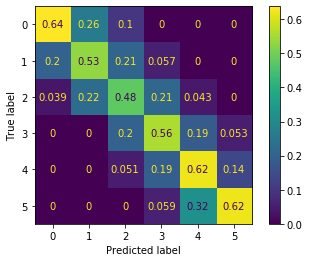

Reward sets:
(0, 0): [-2, 0, 0, -1, 0, -1, 0, -2, -2, 0, -2, -1, -2, -1, 0, -1, -1, 0, -1, -1, -1, -2, -2, 0, 0, -2, -2, 0, -1, -1, 0, -1, -2, -1, -3, -3, -1, -2, 0, 0, -1, -2, -1, 0, -1, -2, -1, 0, -1, -1, -1, -1, -1, -1, -2, 0, 0, -1, 0, -1, -1, 0, -1, -2, -1, -1, -1, 0, -2, -1, -1, -1, -1, -1, -2, -3, -2, -1, 0, -1, 0]
(0, 1): [-1, -2, -1, -1, -1, -2, 0, 0, 0, -1, 0, -2, 0, -2, 0, -1, 0, 0, 0, -1, 0, 0, 0, -1, 0, -1, -2, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, -1, 0, 0, 0, -1, -1, 0, 0, -1, 0, -1, 0, 0, -2, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, 0, 0, -2, 0]
(0, 2): [-1, -1, -1, -1, -1, -1, 0, -1, -1, -2, 0, 0, -1, -3, 0, 0, -3, -1, -2, -1, -1, -3, -2, -2, -1, 0, 0, -2, 0, -1, 0, -2, 0, 0, 0, 0, -2, -1, -1, -2, -2, 0, -1, -1, -1, -2, 0, -3, -1, -1, -1, -1, 0, -1, -1, 0, -1, -1, -2, -1, -1, -1, -2, -1, 0, -2, -1, -1, -3, -3, -1, 0, -1, -2, -1, 0, 0, 0, -1, -1, -1, 0, -1, -1, -1, -1, -1, 0, -2, -1, -1, -1, 0, -2, -1, -2, -1, -2, -1, -1, -1, -1, -3, 0, -2, -1, -1, 0, -1, -1, -2, -1, 0, -2

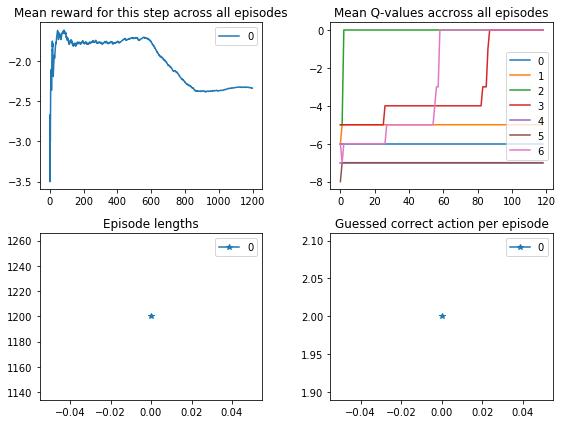

In [21]:
# When we always pick at random, we never end up consistently picking the same action
# so the episode end is never triggered by. 
# Therefore the agent has enough observations to properly estimate the noise matrix
params_new ={
    'max_steps': 1200,
    'num_episodes': 1,
    'noise': True, 
    'surrogate': True, 
    'plots': True, 
    # epsilon min must be high, otherwise we never end up with a convertable matrix
    # and never end up using the surrogate rewards
    'epsilon_min': 0.5,
    'diag': 0.5
    }
params = default_params() | params_new
plot_mean_q_values(params = params)

100%|██████████| 100/100 [00:00<00:00, 381.84it/s]


Accuracy: 70.0
Mean episode length: 50.0
Last reward processor:
Estimated confusion matrix:


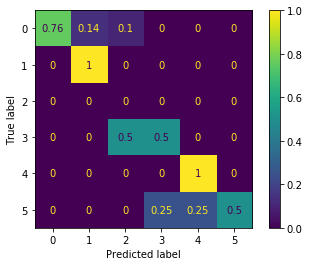

Reward sets:
(0, 1): [0, -2, 0, 0, 0, 0, -2, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, -2, 0, 0, 0, -1, -1, 0, 0, 0, 0, -1, 0, -1, 0, 0, 0, 0, 0, -1, 0, -1]
(0, 2): [-1, -1, -1, -1]
(0, 4): [-3, -2]
(0, 5): [-4]
(0, 6): [-4, -5, -3, -5]
Reward set counts:
Key (0, 1): 38 items
Key (0, 2): 4 items
Key (0, 4): 2 items
Key (0, 5): 1 items
Key (0, 6): 4 items


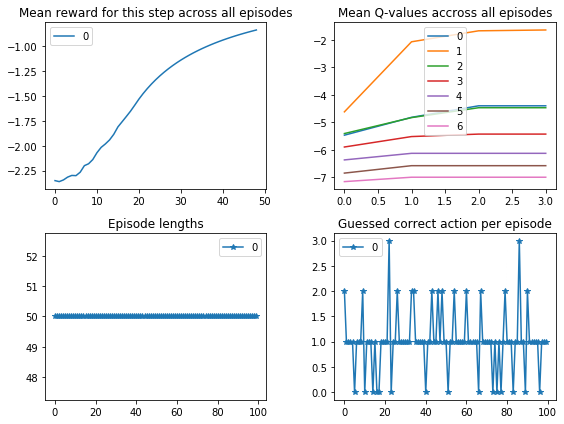

In [13]:
params_new ={
    'max_steps': 120,
    'num_episodes': 100,
    'noise': True, 
    'surrogate': True, 
    'plots': True,
    'diag': 0.5
    }
params = default_params() | params_new
plot_mean_q_values(params = params)

100%|██████████| 100/100 [00:00<00:00, 416.62it/s]


Accuracy: 81.0
Mean episode length: 50.0
Last reward processor:
Estimated confusion matrix:


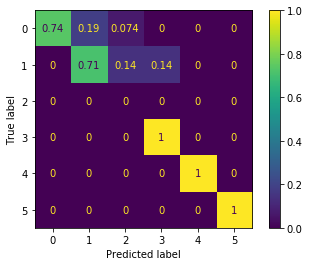

Reward sets:
(0, 0): [-1, -3, -1]
(0, 1): [0, -1, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, -1, 0, -2, 0, -2, 0, 0, 0, -1, 0, -1, 0, 0, 0, 0, 0, 0, -1, -2, 0, -1, -1, 0, -1]
(0, 2): [-1, -1]
(0, 3): [-1, -2]
(0, 4): [-3, -3]
(0, 5): [-4]
(0, 6): [-5, -5, -5]
Reward set counts:
Key (0, 0): 3 items
Key (0, 1): 36 items
Key (0, 2): 2 items
Key (0, 3): 2 items
Key (0, 4): 2 items
Key (0, 5): 1 items
Key (0, 6): 3 items


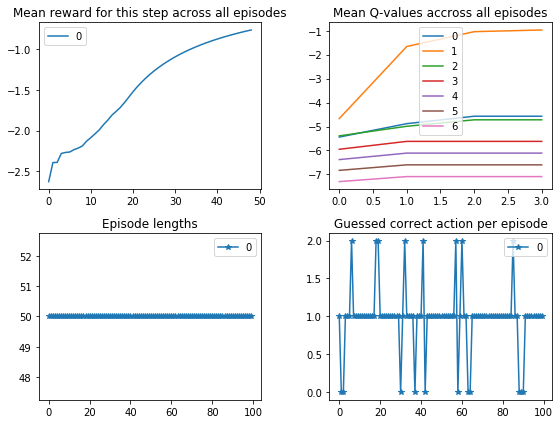

In [13]:
params_new ={
    'noise': True, 
    'surrogate': True, 
    'plots': True, 
    # 'surrogate_c_interval': 10,
    }
params = default_params() | params_new
plot_mean_q_values(params = params)

# Sanity check

In [14]:
params = default_params()

print('Accuracy should be higher, timesteps should be lower')

params['noise'] = False
params['surrogate'] = False
q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy, _ = qLearningExperiment(params=params)
mean_episode_length = np.mean(episode_lengths)
print(accuracy, mean_episode_length) 

params['noise'] = True
params['surrogate'] = False
q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy, _ = qLearningExperiment(params=params)
mean_episode_length = np.mean(episode_lengths)
print(accuracy, mean_episode_length) 

params['noise'] = True
params['surrogate'] = True
q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy, _ = qLearningExperiment(params=params)
mean_episode_length = np.mean(episode_lengths)
print(accuracy, mean_episode_length) 

Accuracy should be higher, timesteps should be lower


100%|██████████| 100/100 [00:00<00:00, 685.43it/s]


100.0 50.0


100%|██████████| 100/100 [00:00<00:00, 546.12it/s]


72.0 50.0


100%|██████████| 100/100 [00:00<00:00, 460.94it/s]

80.0 50.0


# Bayesian optimization

In [15]:
# | 24        | 100.0     | 0.9026    | 826.9     | 0.0       | 73.21     |
# this with noise True and surrogate False
# no alpha decay
# | 184       | 99.0      | 0.8236    | 243.1     | 0.5114    | 0.2529    | 70.53     | 0.04431   | 0.8871    | 67.76     |

In [16]:
from bayes_opt import BayesianOptimization

In [17]:
def objective(
        alpha,
        alpha_decay,
        alpha_min,
        epsilon,
        epsilon_decay,
        epsilon_min,
        gamma,
        surrogate_c_interval,
        ):
    # # 'surrogate_c_interval': [1, 2, 5, 10, 20, 40]
    # # 'surrogate_lr'    
    # convergence_number_of_consequent_actions
    # intial_q_values: [0, -7]

    # surrogate_c_interval = int(surrogate_c_interval)

    new_params = {
        'alpha': alpha, 
        'alpha_decay': alpha_decay,
        'alpha_min': alpha_min,
        'epsilon': epsilon, 
        'epsilon_decay': epsilon_decay,
        'epsilon_min': epsilon_min,
        'gamma': gamma,
        # 'plots': False,   
        'surrogate_c_interval': surrogate_c_interval,
        #
        'noise': True,
        'surrogate': True,
        # 'diag': 0.9     
    }

    params = default_params() | new_params

    q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy, _ = qLearningExperiment(params=params)
    


    # params['surrogate'] = False
    # q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy_no_surrogate, _ = qLearningExperiment(params=params)


    # accuracy = accuracy_surrogate - accuracy_no_surrogate
    
    mean_episode_length = np.mean(episode_lengths)
    print(mean_episode_length)
    # return -mean_episode_length
    return accuracy

optimizer = BayesianOptimization(
    f=objective,
    pbounds={
        'alpha': (0, 1), 
        'alpha_decay': (1, 1000),
        'alpha_min': (0, 1),
        'epsilon': (0, 1), 
        'epsilon_decay': (10, 80),
        'epsilon_min': (0, 1),
        'gamma': (0, 1),
        'surrogate_c_interval': (1, 120)
        },
    random_state=1,
)

# n_iter: How many steps of bayesian optimization you want to perform. 
# The more steps the more likely to find a good maximum you are.
# init_points: How many steps of random exploration you want to perform.
# Random exploration can help by diversifying the exploration space.
optimizer.maximize(
    init_points=100,
    n_iter=100,
)

best_params = optimizer.max['params']

print(optimizer.max)

|   iter    |  target   |   alpha   | alpha_... | alpha_min |  epsilon  | epsilo... | epsilo... |   gamma   | surrog... |
-------------------------------------------------------------------------------------------------------------------------


100%|██████████| 100/100 [00:00<00:00, 386.07it/s]


62.34
| 1         | 37.0      | 0.417     | 720.6     | 0.0001144 | 0.3023    | 20.27     | 0.09234   | 0.1863    | 42.12     |


100%|██████████| 100/100 [00:00<00:00, 288.61it/s]


120.0
| 2         | 46.0      | 0.3968    | 539.3     | 0.4192    | 0.6852    | 24.31     | 0.8781    | 0.02739   | 80.79     |


100%|██████████| 100/100 [00:00<00:00, 295.41it/s]


92.66
| 3         | 41.0      | 0.4173    | 559.1     | 0.1404    | 0.1981    | 66.05     | 0.9683    | 0.3134    | 83.39     |


100%|██████████| 100/100 [00:00<00:00, 441.06it/s]


58.35
| 4         | 41.0      | 0.8764    | 894.7     | 0.08504   | 0.03905   | 21.89     | 0.8781    | 0.09835   | 51.11     |


100%|██████████| 100/100 [00:00<00:00, 243.62it/s]


119.25
| 5         | 58.0      | 0.9579    | 533.6     | 0.6919    | 0.3155    | 58.06     | 0.8346    | 0.01829   | 90.27     |


100%|██████████| 100/100 [00:00<00:00, 248.57it/s]


120.0
| 6         | 75.0      | 0.9889    | 748.4     | 0.2804    | 0.7893    | 17.23     | 0.4479    | 0.9086    | 35.94     |


100%|██████████| 100/100 [00:00<00:00, 264.34it/s]


109.8
| 7         | 38.0      | 0.2878    | 130.9     | 0.01937   | 0.6788    | 24.81     | 0.2655    | 0.4916    | 7.35      |


100%|██████████| 100/100 [00:00<00:00, 257.30it/s]


118.98
| 8         | 60.0      | 0.5741    | 147.6     | 0.5893    | 0.6998    | 17.16     | 0.4141    | 0.6944    | 50.29     |


100%|██████████| 100/100 [00:00<00:00, 270.38it/s]


120.0
| 9         | 47.0      | 0.04995   | 536.4     | 0.6638    | 0.5149    | 76.12     | 0.5866    | 0.9034    | 17.36     |


100%|██████████| 100/100 [00:00<00:00, 331.28it/s]


86.34
| 10        | 43.0      | 0.1393    | 807.6     | 0.3977    | 0.1654    | 74.93     | 0.3478    | 0.7508    | 87.39     |


100%|██████████| 100/100 [00:00<00:00, 234.69it/s]


119.69
| 11        | 63.0      | 0.8833    | 624.0     | 0.7509    | 0.3489    | 28.89     | 0.8959    | 0.4281    | 115.8     |


100%|██████████| 100/100 [00:00<00:00, 265.81it/s]


120.0
| 12        | 62.0      | 0.6634    | 622.1     | 0.1147    | 0.9495    | 41.49     | 0.5784    | 0.4081    | 29.21     |


100%|██████████| 100/100 [00:00<00:00, 256.89it/s]


119.53
| 13        | 79.0      | 0.9034    | 574.1     | 0.00287   | 0.6171    | 32.87     | 0.5271    | 0.8859    | 43.52     |


100%|██████████| 100/100 [00:00<00:00, 310.34it/s]


120.0
| 14        | 45.0      | 0.9085    | 623.7     | 0.01582   | 0.9294    | 58.36     | 0.9973    | 0.1723    | 17.32     |


100%|██████████| 100/100 [00:00<00:00, 285.45it/s]


120.0
| 15        | 59.0      | 0.9326    | 697.1     | 0.066     | 0.7555    | 62.77     | 0.923     | 0.7115    | 15.79     |


100%|██████████| 100/100 [00:00<00:00, 277.03it/s]


105.02
| 16        | 41.0      | 0.01988   | 27.18     | 0.02831   | 0.2462    | 70.2      | 0.5388    | 0.5528    | 101.2     |


100%|██████████| 100/100 [00:00<00:00, 593.35it/s]


50.47
| 17        | 77.0      | 0.1242    | 279.9     | 0.5858    | 0.9696    | 49.27     | 0.01865   | 0.8006    | 28.72     |


100%|██████████| 100/100 [00:00<00:00, 298.23it/s]


95.6
| 18        | 73.0      | 0.8071    | 388.5     | 0.8635    | 0.7471    | 48.94     | 0.1365    | 0.05992   | 15.44     |


100%|██████████| 100/100 [00:00<00:00, 568.10it/s]


50.0
| 19        | 27.0      | 0.04455   | 108.4     | 0.2257    | 0.713     | 49.18     | 0.01256   | 0.07197   | 116.1     |


100%|██████████| 100/100 [00:00<00:00, 266.06it/s]


119.85
| 20        | 49.0      | 0.5681    | 204.1     | 0.2523    | 0.7438    | 23.68     | 0.5814    | 0.97      | 101.8     |


100%|██████████| 100/100 [00:00<00:00, 513.23it/s]


51.35
| 21        | 33.0      | 0.2398    | 494.3     | 0.62      | 0.829     | 20.98     | 0.01858   | 0.07002   | 58.88     |


100%|██████████| 100/100 [00:00<00:00, 253.22it/s]


120.0
| 22        | 51.0      | 0.6063    | 569.3     | 0.3174    | 0.9886    | 50.58     | 0.3801    | 0.5509    | 89.69     |


100%|██████████| 100/100 [00:00<00:00, 284.27it/s]


97.44
| 23        | 76.0      | 0.6692    | 265.7     | 0.06633   | 0.3701    | 54.08     | 0.2102    | 0.7528    | 8.918     |


100%|██████████| 100/100 [00:00<00:00, 279.69it/s]


120.0
| 24        | 22.0      | 0.2603    | 804.9     | 0.1934    | 0.6395    | 46.73     | 0.9248    | 0.2633    | 8.849     |


100%|██████████| 100/100 [00:00<00:00, 314.69it/s]


90.92
| 25        | 76.0      | 0.7351    | 772.4     | 0.9078    | 0.932     | 10.98     | 0.2344    | 0.6168    | 113.9     |


100%|██████████| 100/100 [00:00<00:00, 263.03it/s]


120.0
| 26        | 70.0      | 0.9502    | 557.1     | 0.9156    | 0.6416    | 37.3      | 0.486     | 0.6043    | 66.4      |


100%|██████████| 100/100 [00:00<00:00, 325.75it/s]


84.6
| 27        | 75.0      | 0.9262    | 918.8     | 0.3949    | 0.9633    | 22.18     | 0.1263    | 0.1351    | 61.17     |


100%|██████████| 100/100 [00:00<00:00, 528.23it/s]


51.19
| 28        | 14.0      | 0.02152   | 948.0     | 0.8271    | 0.01502   | 22.33     | 0.3321    | 0.131     | 97.33     |


100%|██████████| 100/100 [00:00<00:00, 318.85it/s]


120.0
| 29        | 26.0      | 0.3447    | 940.2     | 0.582     | 0.8788    | 69.13     | 0.9054    | 0.4599    | 66.02     |


100%|██████████| 100/100 [00:00<00:00, 270.11it/s]


120.0
| 30        | 61.0      | 0.7986    | 286.4     | 0.4903    | 0.5991    | 11.09     | 0.5935    | 0.4337    | 97.08     |


100%|██████████| 100/100 [00:00<00:00, 310.04it/s]


89.86
| 31        | 39.0      | 0.3152    | 893.0     | 0.5779    | 0.184     | 65.16     | 0.612     | 0.05391   | 51.0      |


100%|██████████| 100/100 [00:00<00:00, 319.96it/s]


120.0
| 32        | 43.0      | 0.6791    | 918.7     | 0.000402  | 0.9768    | 36.36     | 0.9738    | 0.6047    | 99.63     |


100%|██████████| 100/100 [00:00<00:00, 266.41it/s]


119.5
| 33        | 35.0      | 0.5747    | 628.4     | 0.2856    | 0.5868    | 62.5      | 0.8583    | 0.7551    | 84.07     |


100%|██████████| 100/100 [00:00<00:00, 252.95it/s]


120.0
| 34        | 66.0      | 0.8645    | 323.4     | 0.6708    | 0.4509    | 36.75     | 0.4108    | 0.4015    | 38.77     |


100%|██████████| 100/100 [00:00<00:00, 259.12it/s]


120.0
| 35        | 52.0      | 0.6219    | 430.8     | 0.9738    | 0.6778    | 23.9      | 0.4267    | 0.3433    | 95.92     |


100%|██████████| 100/100 [00:00<00:00, 244.70it/s]


116.07
| 36        | 70.0      | 0.88      | 903.9     | 0.6627    | 0.2702    | 27.67     | 0.8549    | 0.5277    | 96.46     |


100%|██████████| 100/100 [00:00<00:00, 262.24it/s]


119.83
| 37        | 53.0      | 0.5725    | 733.4     | 0.519     | 0.7709    | 49.82     | 0.4657    | 0.3427    | 9.117     |


100%|██████████| 100/100 [00:00<00:00, 302.54it/s]


93.83
| 38        | 71.0      | 0.3779    | 80.55     | 0.9828    | 0.1816    | 66.83     | 0.875     | 0.6884    | 68.77     |


100%|██████████| 100/100 [00:00<00:00, 286.04it/s]


102.22
| 39        | 76.0      | 0.161     | 467.4     | 0.3452    | 0.225     | 51.48     | 0.3123    | 0.9163    | 109.2     |


100%|██████████| 100/100 [00:00<00:00, 290.05it/s]


98.17
| 40        | 33.0      | 0.2571    | 111.8     | 0.193     | 0.4996    | 61.0      | 0.2082    | 0.248     | 102.3     |


100%|██████████| 100/100 [00:00<00:00, 336.96it/s]


71.25
| 41        | 35.0      | 0.4158    | 617.1     | 0.2337    | 0.102     | 46.11     | 0.4771    | 0.1527    | 74.99     |


100%|██████████| 100/100 [00:00<00:00, 258.20it/s]


119.56
| 42        | 35.0      | 0.544     | 654.5     | 0.1445    | 0.7515    | 25.54     | 0.5194    | 0.7853    | 3.657     |


100%|██████████| 100/100 [00:00<00:00, 270.74it/s]


120.0
| 43        | 37.0      | 0.3244    | 873.0     | 0.8447    | 0.5384    | 70.66     | 0.9498    | 0.8264    | 102.6     |


100%|██████████| 100/100 [00:00<00:00, 511.35it/s]


52.66
| 44        | 66.0      | 0.09874   | 651.7     | 0.7035    | 0.6102    | 65.97     | 0.03457   | 0.7702    | 88.08     |


100%|██████████| 100/100 [00:00<00:00, 258.56it/s]


117.41
| 45        | 49.0      | 0.2597    | 257.8     | 0.6323    | 0.3453    | 65.76     | 0.4461    | 0.7827    | 118.9     |


100%|██████████| 100/100 [00:00<00:00, 273.73it/s]


120.0
| 46        | 39.0      | 0.3002    | 143.9     | 0.9013    | 0.5416    | 78.23     | 0.6366    | 0.9939    | 65.98     |


100%|██████████| 100/100 [00:00<00:00, 495.11it/s]


53.24
| 47        | 24.0      | 0.5264    | 136.3     | 0.3557    | 0.02622   | 21.23     | 0.7456    | 0.0304    | 44.62     |


100%|██████████| 100/100 [00:00<00:00, 271.95it/s]


102.67
| 48        | 89.0      | 0.8623    | 693.0     | 0.6909    | 0.1886    | 40.93     | 0.5816    | 0.9898    | 25.26     |


100%|██████████| 100/100 [00:00<00:00, 265.29it/s]


119.9
| 49        | 46.0      | 0.2477    | 262.9     | 0.7502    | 0.457     | 13.99     | 0.5085    | 0.212     | 96.03     |


100%|██████████| 100/100 [00:00<00:00, 295.43it/s]


120.0
| 50        | 18.0      | 0.2973    | 28.58     | 0.5934    | 0.8438    | 36.67     | 0.7499    | 0.5111    | 65.37     |


100%|██████████| 100/100 [00:00<00:00, 279.84it/s]


120.0
| 51        | 67.0      | 0.9594    | 804.2     | 0.03232   | 0.7094    | 42.55     | 0.9475    | 0.2214    | 32.78     |


100%|██████████| 100/100 [00:00<00:00, 283.96it/s]


120.0
| 52        | 30.0      | 0.08147   | 429.2     | 0.109     | 0.6338    | 66.21     | 0.6968    | 0.7662    | 41.75     |


100%|██████████| 100/100 [00:00<00:00, 434.73it/s]


62.45
| 53        | 55.0      | 0.8459    | 429.3     | 0.824     | 0.6265    | 20.04     | 0.07839   | 0.01833   | 8.94      |


100%|██████████| 100/100 [00:00<00:00, 292.43it/s]


120.0
| 54        | 10.0      | 0.4586    | 114.2     | 0.02778   | 0.7549    | 37.64     | 0.7469    | 0.4524    | 54.56     |


100%|██████████| 100/100 [00:00<00:00, 510.88it/s]


53.56
| 55        | 73.0      | 0.4781    | 474.5     | 0.8032    | 0.4024    | 73.33     | 0.03706   | 0.7739    | 15.95     |


100%|██████████| 100/100 [00:00<00:00, 539.59it/s]


50.11
| 56        | 57.0      | 0.6185    | 11.35     | 0.5386    | 0.003018  | 76.58     | 0.9054    | 0.796     | 109.9     |


100%|██████████| 100/100 [00:00<00:00, 281.24it/s]


120.0
| 57        | 31.0      | 0.1456    | 158.6     | 0.1876    | 0.6225    | 73.41     | 0.99      | 0.7111    | 88.08     |


100%|██████████| 100/100 [00:00<00:00, 255.00it/s]


108.19
| 58        | 56.0      | 0.9093    | 401.5     | 0.2499    | 0.1734    | 18.36     | 0.8126    | 0.1468    | 32.45     |


100%|██████████| 100/100 [00:00<00:00, 267.41it/s]


111.22
| 59        | 82.0      | 0.8191    | 311.3     | 0.9824    | 0.2666    | 47.36     | 0.3145    | 0.9108    | 44.62     |


100%|██████████| 100/100 [00:00<00:00, 449.33it/s]


54.63
| 60        | 23.0      | 0.4336    | 512.8     | 0.9389    | 0.03095   | 60.18     | 0.891     | 0.02729   | 63.12     |


100%|██████████| 100/100 [00:00<00:00, 282.61it/s]


120.0
| 61        | 21.0      | 0.326     | 859.6     | 0.5585    | 0.6902    | 41.7      | 0.6283    | 0.2901    | 2.112     |


100%|██████████| 100/100 [00:00<00:00, 272.16it/s]


108.02
| 62        | 58.0      | 0.5768    | 312.1     | 0.5173    | 0.9164    | 39.85     | 0.2474    | 0.3713    | 111.9     |


100%|██████████| 100/100 [00:00<00:00, 259.54it/s]


111.56
| 63        | 79.0      | 0.9369    | 844.5     | 0.9202    | 0.2279    | 16.12     | 0.2273    | 0.3144    | 21.8      |


100%|██████████| 100/100 [00:00<00:00, 289.53it/s]


98.86
| 64        | 61.0      | 0.6071    | 414.2     | 0.8164    | 0.1851    | 59.13     | 0.2404    | 0.5742    | 42.53     |


100%|██████████| 100/100 [00:00<00:00, 328.40it/s]


86.45
| 65        | 39.0      | 0.05696   | 229.6     | 0.6641    | 0.4973    | 46.33     | 0.1747    | 0.5707    | 119.6     |


100%|██████████| 100/100 [00:00<00:00, 399.09it/s]


72.11
| 66        | 86.0      | 0.8168    | 594.8     | 0.976     | 0.9016    | 51.69     | 0.03243   | 0.09358   | 8.779     |


100%|██████████| 100/100 [00:00<00:00, 336.92it/s]


84.5
| 67        | 75.0      | 0.4517    | 376.1     | 0.9754    | 0.168     | 78.1      | 0.7675    | 0.8242    | 76.28     |


100%|██████████| 100/100 [00:00<00:00, 244.24it/s]


119.45
| 68        | 56.0      | 0.6687    | 477.4     | 0.01314   | 0.353     | 44.45     | 0.7301    | 0.4686    | 55.43     |


100%|██████████| 100/100 [00:00<00:00, 294.31it/s]


96.38
| 69        | 29.0      | 0.1377    | 11.88     | 0.7583    | 0.32      | 78.91     | 0.2202    | 0.3387    | 63.34     |


100%|██████████| 100/100 [00:00<00:00, 248.32it/s]


115.98
| 70        | 72.0      | 0.7549    | 464.4     | 0.1248    | 0.3125    | 45.32     | 0.6738    | 0.7701    | 16.51     |


100%|██████████| 100/100 [00:00<00:00, 527.17it/s]


51.39
| 71        | 34.0      | 0.02292   | 519.6     | 0.81      | 0.0126    | 57.07     | 0.6868    | 0.4492    | 109.9     |


100%|██████████| 100/100 [00:00<00:00, 283.97it/s]


120.0
| 72        | 46.0      | 0.6444    | 6.235     | 0.4844    | 0.8593    | 68.13     | 0.6492    | 0.6737    | 69.84     |


100%|██████████| 100/100 [00:00<00:00, 325.79it/s]


87.51
| 73        | 51.0      | 0.2741    | 561.0     | 0.6717    | 0.3524    | 69.91     | 0.195     | 0.7473    | 35.46     |


100%|██████████| 100/100 [00:00<00:00, 256.86it/s]


118.64
| 74        | 78.0      | 0.7738    | 428.3     | 0.8077    | 0.3535    | 24.96     | 0.7673    | 0.3086    | 88.26     |


100%|██████████| 100/100 [00:00<00:00, 286.10it/s]


97.04
| 75        | 47.0      | 0.7445    | 222.2     | 0.2141    | 0.1989    | 19.98     | 0.3771    | 0.02663   | 14.2      |


100%|██████████| 100/100 [00:00<00:00, 249.28it/s]


112.19
| 76        | 65.0      | 0.6746    | 800.0     | 0.08053   | 0.2317    | 24.53     | 0.9173    | 0.7113    | 66.91     |


100%|██████████| 100/100 [00:00<00:00, 267.84it/s]


119.74
| 77        | 29.0      | 0.3045    | 835.0     | 0.4353    | 0.9235    | 59.42     | 0.478     | 0.1262    | 117.1     |


100%|██████████| 100/100 [00:00<00:00, 256.43it/s]


119.1
| 78        | 35.0      | 0.1598    | 203.4     | 0.4312    | 0.4042    | 20.27     | 0.7293    | 0.1887    | 77.62     |


100%|██████████| 100/100 [00:00<00:00, 274.59it/s]


120.0
| 79        | 66.0      | 0.7543    | 211.5     | 0.601     | 0.7489    | 54.68     | 0.5971    | 0.2955    | 88.06     |


100%|██████████| 100/100 [00:00<00:00, 402.25it/s]


66.07
| 80        | 58.0      | 0.9453    | 426.1     | 0.7822    | 0.05614   | 68.47     | 0.1923    | 0.3951    | 36.71     |


100%|██████████| 100/100 [00:00<00:00, 391.52it/s]


71.34
| 81        | 18.0      | 0.0801    | 904.7     | 0.3702    | 0.5307    | 44.59     | 0.1322    | 0.2065    | 10.07     |


100%|██████████| 100/100 [00:00<00:00, 403.17it/s]


67.24
| 82        | 74.0      | 0.5079    | 262.3     | 0.3571    | 0.1081    | 65.13     | 0.1066    | 0.9857    | 22.08     |


100%|██████████| 100/100 [00:00<00:00, 287.70it/s]


98.91
| 83        | 61.0      | 0.5724    | 45.8      | 0.7871    | 0.1896    | 46.95     | 0.7401    | 0.1499    | 66.58     |


100%|██████████| 100/100 [00:00<00:00, 537.24it/s]


50.26
| 84        | 83.0      | 0.2166    | 759.4     | 0.7229    | 0.1765    | 70.34     | 0.01978   | 0.8602    | 67.51     |


100%|██████████| 100/100 [00:00<00:00, 578.92it/s]


50.0
| 85        | 78.0      | 0.4032    | 759.0     | 0.7169    | 0.9873    | 29.47     | 0.003794  | 0.9339    | 103.1     |


100%|██████████| 100/100 [00:00<00:00, 295.87it/s]


120.0
| 86        | 69.0      | 0.7289    | 517.2     | 0.707     | 0.7805    | 36.24     | 0.7703    | 0.7506    | 73.97     |


100%|██████████| 100/100 [00:00<00:00, 275.72it/s]


102.75
| 87        | 50.0      | 0.4019    | 697.6     | 0.003113  | 0.7749    | 72.75     | 0.2393    | 0.1208    | 27.21     |


100%|██████████| 100/100 [00:00<00:00, 272.50it/s]


109.32
| 88        | 49.0      | 0.3021    | 883.1     | 0.5432    | 0.2867    | 19.68     | 0.2901    | 0.6139    | 39.57     |


100%|██████████| 100/100 [00:00<00:00, 240.94it/s]


119.6
| 89        | 61.0      | 0.4574    | 444.7     | 0.8281    | 0.4263    | 34.2      | 0.675     | 0.2215    | 56.6      |


100%|██████████| 100/100 [00:00<00:00, 262.85it/s]


119.69
| 90        | 36.0      | 0.3148    | 627.2     | 0.8774    | 0.4477    | 64.91     | 0.457     | 0.6562    | 16.69     |


100%|██████████| 100/100 [00:00<00:00, 266.45it/s]


120.0
| 91        | 60.0      | 0.433     | 909.4     | 0.6055    | 0.7668    | 45.33     | 0.4981    | 0.8429    | 9.069     |


100%|██████████| 100/100 [00:00<00:00, 265.73it/s]


106.17
| 92        | 68.0      | 0.5733    | 942.8     | 0.5179    | 0.1945    | 69.36     | 0.2516    | 0.7007    | 65.29     |


100%|██████████| 100/100 [00:00<00:00, 488.88it/s]


52.6
| 93        | 35.0      | 0.9488    | 624.7     | 0.838     | 0.007933  | 79.25     | 0.07771   | 0.3221    | 113.6     |


100%|██████████| 100/100 [00:00<00:00, 264.17it/s]


118.55
| 94        | 42.0      | 0.008939  | 822.9     | 0.8612    | 0.4398    | 27.9      | 0.8027    | 0.4779    | 16.99     |


100%|██████████| 100/100 [00:00<00:00, 273.02it/s]


120.0
| 95        | 61.0      | 0.9278    | 896.1     | 0.4915    | 0.8567    | 39.3      | 0.6835    | 0.398     | 61.18     |


100%|██████████| 100/100 [00:00<00:00, 533.71it/s]


50.0
| 96        | 41.0      | 0.1896    | 965.0     | 0.2942    | 0.1035    | 20.1      | 0.01409   | 0.7159    | 68.18     |


100%|██████████| 100/100 [00:00<00:00, 257.27it/s]


119.54
| 97        | 68.0      | 0.7946    | 507.6     | 0.7918    | 0.6958    | 64.45     | 0.4065    | 0.6478    | 22.4      |


100%|██████████| 100/100 [00:00<00:00, 273.79it/s]


106.19
| 98        | 43.0      | 0.3218    | 173.4     | 0.4086    | 0.2414    | 38.48     | 0.9752    | 0.3203    | 117.9     |


100%|██████████| 100/100 [00:00<00:00, 276.33it/s]


120.0
| 99        | 69.0      | 0.6363    | 375.7     | 0.8575    | 0.6196    | 27.64     | 0.7929    | 0.4329    | 43.54     |


100%|██████████| 100/100 [00:00<00:00, 266.59it/s]


120.0
| 100       | 31.0      | 0.3303    | 697.7     | 0.2687    | 0.8083    | 30.67     | 0.5441    | 0.4879    | 102.8     |


100%|██████████| 100/100 [00:00<00:00, 255.62it/s]


118.04
| 101       | 26.0      | 0.03706   | 774.1     | 0.1256    | 0.6185    | 10.73     | 0.5386    | 0.003018  | 114.2     |


100%|██████████| 100/100 [00:00<00:00, 243.53it/s]


119.42
| 102       | 33.0      | 0.8054    | 152.6     | 0.3237    | 0.4322    | 77.15     | 0.6474    | 0.544     | 113.8     |


100%|██████████| 100/100 [00:00<00:00, 426.91it/s]


56.01
| 103       | 31.0      | 0.2829    | 836.9     | 0.01909   | 0.2006    | 34.29     | 0.05477   | 0.5307    | 49.73     |


100%|██████████| 100/100 [00:00<00:00, 241.92it/s]


104.22
| 104       | 69.0      | 0.3659    | 469.7     | 0.5373    | 0.2653    | 79.64     | 0.2238    | 0.2518    | 107.4     |


100%|██████████| 100/100 [00:00<00:00, 245.18it/s]


119.98
| 105       | 43.0      | 0.1286    | 21.81     | 0.8872    | 0.7994    | 66.18     | 0.4713    | 0.8262    | 72.46     |


100%|██████████| 100/100 [00:00<00:00, 227.49it/s]


120.0
| 106       | 71.0      | 0.9545    | 508.5     | 0.3294    | 0.5376    | 51.39     | 0.5527    | 0.6357    | 105.8     |


100%|██████████| 100/100 [00:00<00:00, 229.93it/s]


119.36
| 107       | 53.0      | 0.09118   | 466.7     | 0.1003    | 0.706     | 46.0      | 0.4872    | 0.9819    | 24.57     |


100%|██████████| 100/100 [00:00<00:00, 233.96it/s]


117.9
| 108       | 29.0      | 0.08246   | 250.3     | 0.2219    | 0.8699    | 25.99     | 0.4157    | 0.3799    | 114.0     |


100%|██████████| 100/100 [00:00<00:00, 397.87it/s]


60.37
| 109       | 47.0      | 0.2417    | 840.3     | 0.8518    | 0.5874    | 23.88     | 0.111     | 0.7203    | 74.98     |


100%|██████████| 100/100 [00:00<00:00, 214.03it/s]


95.8
| 110       | 37.0      | 0.3043    | 504.6     | 0.002496  | 0.8423    | 60.58     | 0.2315    | 0.04112   | 91.88     |


100%|██████████| 100/100 [00:00<00:00, 294.24it/s]


92.61
| 111       | 38.0      | 0.1512    | 390.3     | 0.7288    | 0.6121    | 78.66     | 0.2008    | 0.5446    | 14.77     |


100%|██████████| 100/100 [00:00<00:00, 215.74it/s]


107.73
| 112       | 80.0      | 0.6462    | 856.3     | 0.3537    | 0.2252    | 43.68     | 0.4574    | 0.9138    | 50.03     |


100%|██████████| 100/100 [00:00<00:00, 249.20it/s]


112.72
| 113       | 54.0      | 0.3222    | 152.7     | 0.4066    | 0.7223    | 13.08     | 0.3115    | 0.1475    | 4.311     |


100%|██████████| 100/100 [00:00<00:00, 233.92it/s]


120.0
| 114       | 41.0      | 0.1593    | 603.1     | 0.1481    | 0.5014    | 65.81     | 0.7556    | 0.5507    | 31.36     |


100%|██████████| 100/100 [00:00<00:00, 199.33it/s]


119.45
| 115       | 36.0      | 0.4164    | 97.99     | 0.08714   | 0.4179    | 31.33     | 0.7092    | 0.05934   | 18.59     |


100%|██████████| 100/100 [00:00<00:00, 362.76it/s]


63.77
| 116       | 56.0      | 0.3053    | 447.6     | 0.1256    | 0.2499    | 72.81     | 0.09095   | 0.7328    | 80.77     |


100%|██████████| 100/100 [00:00<00:00, 213.39it/s]


118.08
| 117       | 77.0      | 0.6784    | 741.6     | 0.8726    | 0.6291    | 16.62     | 0.3629    | 0.6375    | 7.078     |


100%|██████████| 100/100 [00:00<00:00, 237.89it/s]


112.22
| 118       | 79.0      | 0.9457    | 987.3     | 0.6256    | 0.2373    | 70.5      | 0.6155    | 0.6717    | 8.256     |


100%|██████████| 100/100 [00:00<00:00, 290.74it/s]


71.31
| 119       | 49.0      | 0.5648    | 808.8     | 0.9738    | 0.08996   | 43.01     | 0.3071    | 0.1112    | 90.01     |


100%|██████████| 100/100 [00:00<00:00, 218.83it/s]


120.0
| 120       | 71.0      | 0.8138    | 912.2     | 0.6691    | 0.6231    | 43.06     | 0.8112    | 0.5449    | 108.6     |


100%|██████████| 100/100 [00:00<00:00, 251.85it/s]


120.0
| 121       | 68.0      | 0.8348    | 844.3     | 0.6595    | 0.7349    | 36.84     | 0.6682    | 0.3383    | 9.261     |


100%|██████████| 100/100 [00:00<00:00, 245.70it/s]


119.5
| 122       | 53.0      | 0.7684    | 198.6     | 0.7618    | 0.9706    | 46.89     | 0.3903    | 0.212     | 81.68     |


100%|██████████| 100/100 [00:00<00:00, 309.21it/s]


57.77
| 123       | 77.0      | 0.916     | 297.8     | 0.7926    | 0.6722    | 30.5      | 0.04177   | 0.6387    | 29.49     |


100%|██████████| 100/100 [00:00<00:00, 210.83it/s]


119.92
| 124       | 37.0      | 0.3104    | 922.3     | 0.7517    | 0.4567    | 66.52     | 0.5592    | 0.4045    | 84.84     |


100%|██████████| 100/100 [00:00<00:00, 237.12it/s]


117.27
| 125       | 42.0      | 0.6601    | 40.8      | 0.2272    | 0.3149    | 58.18     | 0.4732    | 0.01367   | 30.67     |


100%|██████████| 100/100 [00:00<00:00, 257.70it/s]


120.0
| 126       | 73.0      | 0.8908    | 811.7     | 0.7692    | 0.8749    | 67.0      | 0.7013    | 0.4142    | 28.64     |


100%|██████████| 100/100 [00:00<00:00, 269.60it/s]


103.4
| 127       | 48.0      | 0.1388    | 318.3     | 0.7932    | 0.9068    | 76.37     | 0.2568    | 0.6069    | 106.8     |


100%|██████████| 100/100 [00:00<00:00, 196.92it/s]


119.9
| 128       | 45.0      | 0.4646    | 972.0     | 0.2676    | 0.8335    | 51.16     | 0.4854    | 0.1836    | 48.43     |


100%|██████████| 100/100 [00:00<00:00, 241.45it/s]


118.04
| 129       | 72.0      | 0.8273    | 124.3     | 0.4054    | 0.3544    | 46.25     | 0.9928    | 0.1839    | 55.91     |


100%|██████████| 100/100 [00:00<00:00, 229.71it/s]


120.0
| 130       | 58.0      | 0.537     | 969.1     | 0.7768    | 0.4985    | 15.95     | 0.9863    | 0.1314    | 35.41     |


100%|██████████| 100/100 [00:00<00:00, 230.37it/s]


118.78
| 131       | 44.0      | 0.1382    | 176.3     | 0.1294    | 0.7642    | 10.55     | 0.4724    | 0.4173    | 33.77     |


100%|██████████| 100/100 [00:00<00:00, 225.73it/s]


120.0
| 132       | 25.0      | 0.8985    | 283.0     | 0.3266    | 0.899     | 60.83     | 0.826     | 0.4756    | 13.28     |


100%|██████████| 100/100 [00:00<00:00, 269.10it/s]


120.0
| 133       | 61.0      | 0.443     | 821.6     | 0.3417    | 0.6875    | 74.54     | 0.9541    | 0.941     | 56.83     |


100%|██████████| 100/100 [00:00<00:00, 228.89it/s]


94.17
| 134       | 66.0      | 0.696     | 808.1     | 0.008623  | 0.9809    | 33.49     | 0.1289    | 0.311     | 33.87     |


100%|██████████| 100/100 [00:00<00:00, 245.00it/s]


103.77
| 135       | 36.0      | 0.4681    | 95.72     | 0.2457    | 0.3042    | 38.86     | 0.2652    | 0.2029    | 81.29     |


100%|██████████| 100/100 [00:00<00:00, 283.93it/s]


76.05
| 136       | 54.0      | 0.5627    | 434.0     | 0.5677    | 0.105     | 59.59     | 0.1437    | 0.7369    | 80.54     |


100%|██████████| 100/100 [00:00<00:00, 211.66it/s]


104.71
| 137       | 65.0      | 0.8983    | 303.4     | 0.2525    | 0.2209    | 11.05     | 0.4275    | 0.411     | 77.7      |


100%|██████████| 100/100 [00:00<00:00, 263.55it/s]


120.0
| 138       | 18.0      | 0.1796    | 128.6     | 0.02728   | 0.7183    | 69.39     | 0.8256    | 0.2732    | 17.54     |


100%|██████████| 100/100 [00:00<00:00, 429.97it/s]


53.34
| 139       | 23.0      | 0.5998    | 306.3     | 0.1153    | 0.02101   | 11.7      | 0.881     | 0.05357   | 105.3     |


100%|██████████| 100/100 [00:00<00:00, 181.77it/s]


119.57
| 140       | 42.0      | 0.491     | 108.9     | 0.1021    | 0.5465    | 42.98     | 0.4734    | 0.7893    | 12.12     |


100%|██████████| 100/100 [00:00<00:00, 236.58it/s]


118.76
| 141       | 69.0      | 0.7877    | 273.7     | 0.3834    | 0.3776    | 36.55     | 0.3966    | 0.2057    | 23.2      |


100%|██████████| 100/100 [00:00<00:00, 366.78it/s]


65.07
| 142       | 30.0      | 0.3348    | 675.7     | 0.535     | 0.07981   | 35.78     | 0.6801    | 0.3919    | 80.14     |


100%|██████████| 100/100 [00:00<00:00, 224.08it/s]


91.03
| 143       | 81.0      | 0.761     | 73.63     | 0.7223    | 0.1582    | 51.1      | 0.3536    | 0.7491    | 17.9      |


100%|██████████| 100/100 [00:00<00:00, 259.25it/s]


107.31
| 144       | 79.0      | 0.2237    | 20.17     | 0.0494    | 0.448     | 22.12     | 0.3067    | 0.9       | 25.85     |


100%|██████████| 100/100 [00:00<00:00, 222.55it/s]


96.22
| 145       | 62.0      | 0.5488    | 52.4      | 0.5341    | 0.1568    | 41.23     | 0.2626    | 0.5867    | 66.38     |


100%|██████████| 100/100 [00:00<00:00, 308.68it/s]


74.58
| 146       | 29.0      | 0.2769    | 323.4     | 0.1088    | 0.1774    | 37.89     | 0.1261    | 0.06607   | 39.06     |


100%|██████████| 100/100 [00:00<00:00, 241.40it/s]


120.0
| 147       | 7.0       | 0.4868    | 150.9     | 0.3055    | 0.93      | 13.97     | 0.8859    | 0.08759   | 117.2     |


100%|██████████| 100/100 [00:00<00:00, 230.22it/s]


114.3
| 148       | 46.0      | 0.09622   | 717.7     | 0.1747    | 0.7084    | 25.75     | 0.4109    | 0.5178    | 77.69     |


100%|██████████| 100/100 [00:00<00:00, 216.04it/s]


119.76
| 149       | 66.0      | 0.3632    | 720.8     | 0.7913    | 0.46      | 29.43     | 0.7847    | 0.02632   | 80.91     |


100%|██████████| 100/100 [00:00<00:00, 283.13it/s]


94.14
| 150       | 43.0      | 0.2503    | 190.3     | 0.2448    | 0.2367    | 43.92     | 0.1933    | 0.3883    | 43.05     |


100%|██████████| 100/100 [00:00<00:00, 247.25it/s]


78.86
| 151       | 33.0      | 0.385     | 210.1     | 0.06173   | 0.149     | 79.85     | 0.7163    | 0.09798   | 49.98     |


100%|██████████| 100/100 [00:00<00:00, 417.35it/s]


53.34
| 152       | 21.0      | 0.345     | 547.9     | 0.6835    | 0.01781   | 16.5      | 0.5806    | 0.1434    | 114.0     |


100%|██████████| 100/100 [00:00<00:00, 289.07it/s]


60.29
| 153       | 40.0      | 0.2512    | 289.7     | 0.2718    | 0.501     | 45.62     | 0.06904   | 0.3259    | 66.84     |


100%|██████████| 100/100 [00:00<00:00, 234.91it/s]


119.4
| 154       | 47.0      | 0.201     | 557.1     | 0.6229    | 0.5389    | 69.65     | 0.4876    | 0.8618    | 75.01     |


100%|██████████| 100/100 [00:00<00:00, 249.87it/s]


108.26
| 155       | 49.0      | 0.2464    | 613.1     | 0.1728    | 0.6105    | 48.94     | 0.2735    | 0.09314   | 99.26     |


100%|██████████| 100/100 [00:00<00:00, 216.39it/s]


119.37
| 156       | 62.0      | 0.6993    | 669.9     | 0.5853    | 0.7589    | 37.41     | 0.5041    | 0.4946    | 20.26     |


100%|██████████| 100/100 [00:00<00:00, 228.96it/s]


119.9
| 157       | 63.0      | 0.8471    | 182.9     | 0.9841    | 0.4554    | 63.54     | 0.7231    | 0.2857    | 10.67     |


100%|██████████| 100/100 [00:00<00:00, 231.13it/s]


120.0
| 158       | 61.0      | 0.8503    | 907.1     | 0.9833    | 0.5947    | 36.68     | 0.6635    | 0.1728    | 58.01     |


100%|██████████| 100/100 [00:00<00:00, 226.31it/s]


120.0
| 159       | 66.0      | 0.8829    | 463.6     | 0.3203    | 0.6764    | 32.03     | 0.7953    | 0.7217    | 103.8     |


100%|██████████| 100/100 [00:00<00:00, 282.03it/s]


93.25
| 160       | 41.0      | 0.1253    | 558.2     | 0.2755    | 0.9558    | 79.73     | 0.181     | 0.3707    | 51.43     |


100%|██████████| 100/100 [00:00<00:00, 214.19it/s]


106.29
| 161       | 80.0      | 0.7629    | 626.3     | 0.9436    | 0.1935    | 29.65     | 0.4263    | 0.4505    | 99.14     |


100%|██████████| 100/100 [00:00<00:00, 450.33it/s]


52.86
| 162       | 82.0      | 0.5668    | 730.0     | 0.2777    | 0.03109   | 58.58     | 0.9146    | 0.902     | 37.64     |


100%|██████████| 100/100 [00:00<00:00, 186.20it/s]


120.0
| 163       | 50.0      | 0.5761    | 815.3     | 0.3934    | 0.6037    | 33.89     | 0.7181    | 0.2471    | 21.03     |


100%|██████████| 100/100 [00:00<00:00, 235.62it/s]


114.93
| 164       | 67.0      | 0.3391    | 784.3     | 0.2078    | 0.2938    | 76.16     | 0.4204    | 0.8607    | 71.19     |


100%|██████████| 100/100 [00:00<00:00, 253.86it/s]


94.13
| 165       | 59.0      | 0.5534    | 644.3     | 0.2066    | 0.2031    | 45.89     | 0.2362    | 0.4597    | 51.73     |


100%|██████████| 100/100 [00:00<00:00, 233.17it/s]


116.35
| 166       | 78.0      | 0.4663    | 452.3     | 0.8597    | 0.3126    | 32.23     | 0.4407    | 0.7952    | 12.52     |


100%|██████████| 100/100 [00:00<00:00, 362.17it/s]


59.95
| 167       | 43.0      | 0.3602    | 167.6     | 0.89      | 0.06445   | 42.43     | 0.733     | 0.7702    | 76.8      |


100%|██████████| 100/100 [00:00<00:00, 202.90it/s]


120.0
| 168       | 42.0      | 0.2401    | 564.1     | 0.9312    | 0.4829    | 42.84     | 0.9979    | 0.2957    | 76.92     |


100%|██████████| 100/100 [00:00<00:00, 477.00it/s]


50.68
| 169       | 36.0      | 0.1493    | 448.3     | 0.4433    | 0.9638    | 11.44     | 0.0218    | 0.6151    | 26.75     |


100%|██████████| 100/100 [00:00<00:00, 203.56it/s]


120.0
| 170       | 61.0      | 0.9218    | 834.5     | 0.6094    | 0.7925    | 19.58     | 0.7414    | 0.6769    | 48.99     |


100%|██████████| 100/100 [00:00<00:00, 368.11it/s]


62.2
| 171       | 71.0      | 0.429     | 71.22     | 0.05555   | 0.3721    | 79.45     | 0.07597   | 0.8317    | 91.16     |


100%|██████████| 100/100 [00:00<00:00, 205.82it/s]


116.35
| 172       | 77.0      | 0.7471    | 292.4     | 0.9912    | 0.307     | 32.84     | 0.9725    | 0.771     | 70.1      |


100%|██████████| 100/100 [00:00<00:00, 429.05it/s]


59.64
| 173       | 78.0      | 0.08901   | 976.2     | 0.3424    | 0.9463    | 42.09     | 0.07264   | 0.8932    | 49.33     |


100%|██████████| 100/100 [00:00<00:00, 189.11it/s]


119.15
| 174       | 58.0      | 0.2818    | 226.3     | 0.2214    | 0.6262    | 26.31     | 0.4514    | 0.9088    | 64.65     |


100%|██████████| 100/100 [00:00<00:00, 315.10it/s]


81.88
| 175       | 77.0      | 0.3557    | 290.0     | 0.1136    | 0.4265    | 69.33     | 0.1635    | 0.8645    | 57.22     |


100%|██████████| 100/100 [00:00<00:00, 246.29it/s]


119.4
| 176       | 62.0      | 0.4478    | 472.4     | 0.4956    | 0.9726    | 73.27     | 0.4903    | 0.9296    | 34.1      |


100%|██████████| 100/100 [00:00<00:00, 207.81it/s]


105.63
| 177       | 65.0      | 0.7864    | 517.0     | 0.2657    | 0.1927    | 76.44     | 0.5201    | 0.4273    | 54.33     |


100%|██████████| 100/100 [00:00<00:00, 433.89it/s]


53.67
| 178       | 31.0      | 0.6972    | 908.0     | 0.2677    | 0.01574   | 37.15     | 0.2946    | 0.4269    | 99.03     |


100%|██████████| 100/100 [00:00<00:00, 194.28it/s]


120.0
| 179       | 31.0      | 0.2176    | 700.6     | 0.823     | 0.6037    | 79.33     | 0.6043    | 0.2288    | 48.36     |


100%|██████████| 100/100 [00:00<00:00, 234.75it/s]


117.69
| 180       | 68.0      | 0.0672    | 373.3     | 0.8321    | 0.3522    | 79.97     | 0.5312    | 0.9312    | 55.92     |


100%|██████████| 100/100 [00:00<00:00, 266.84it/s]


120.0
| 181       | 49.0      | 0.3343    | 717.1     | 0.8582    | 0.8027    | 18.67     | 0.6304    | 0.671     | 5.2       |


100%|██████████| 100/100 [00:00<00:00, 193.83it/s]


119.52
| 182       | 64.0      | 0.851     | 890.3     | 0.6537    | 0.6242    | 77.87     | 0.5059    | 0.5192    | 13.81     |


100%|██████████| 100/100 [00:00<00:00, 233.79it/s]


114.81
| 183       | 38.0      | 0.3922    | 656.0     | 0.215     | 0.309     | 78.09     | 0.8175    | 0.007174  | 52.74     |


100%|██████████| 100/100 [00:00<00:00, 400.88it/s]


53.49
| 184       | 93.0      | 0.8236    | 243.1     | 0.5114    | 0.2529    | 70.53     | 0.04431   | 0.8871    | 67.76     |


100%|██████████| 100/100 [00:00<00:00, 290.04it/s]


60.02
| 185       | 32.0      | 0.5739    | 573.7     | 0.505     | 0.05187   | 52.43     | 0.8983    | 0.1413    | 117.1     |


100%|██████████| 100/100 [00:00<00:00, 347.05it/s]


63.11
| 186       | 77.0      | 0.9205    | 502.4     | 0.9033    | 0.7448    | 45.16     | 0.008553  | 0.3741    | 43.22     |


100%|██████████| 100/100 [00:00<00:00, 226.80it/s]


120.0
| 187       | 23.0      | 0.138     | 974.2     | 0.2051    | 0.9607    | 11.16     | 0.8322    | 0.7438    | 104.8     |


100%|██████████| 100/100 [00:00<00:00, 304.27it/s]


86.4
| 188       | 22.0      | 0.1546    | 915.5     | 0.7596    | 0.1715    | 40.86     | 0.9221    | 0.2138    | 89.6      |


100%|██████████| 100/100 [00:00<00:00, 185.86it/s]


120.0
| 189       | 63.0      | 0.7393    | 164.3     | 0.6926    | 0.9813    | 35.13     | 0.4501    | 0.6412    | 108.2     |


100%|██████████| 100/100 [00:00<00:00, 237.88it/s]


120.0
| 190       | 54.0      | 0.9611    | 964.1     | 0.1339    | 0.9143    | 66.84     | 0.5378    | 0.06874   | 26.2      |


100%|██████████| 100/100 [00:00<00:00, 238.36it/s]


119.3
| 191       | 71.0      | 0.345     | 346.9     | 0.7632    | 0.4344    | 23.52     | 0.5956    | 0.0868    | 86.51     |


100%|██████████| 100/100 [00:00<00:00, 202.65it/s]


115.68
| 192       | 56.0      | 0.5583    | 601.3     | 0.6445    | 0.4587    | 61.83     | 0.2877    | 0.4225    | 28.13     |


100%|██████████| 100/100 [00:00<00:00, 292.33it/s]


120.0
| 193       | 13.0      | 0.9504    | 109.9     | 0.2081    | 0.8592    | 52.86     | 0.9365    | 0.01431   | 78.19     |


100%|██████████| 100/100 [00:00<00:00, 190.81it/s]


117.97
| 194       | 65.0      | 0.1532    | 745.6     | 0.3588    | 0.7805    | 76.47     | 0.3405    | 0.8447    | 41.38     |


100%|██████████| 100/100 [00:00<00:00, 239.80it/s]


120.0
| 195       | 52.0      | 0.6319    | 196.4     | 0.5272    | 0.4709    | 38.86     | 0.488     | 0.5778    | 59.71     |


100%|██████████| 100/100 [00:00<00:00, 249.75it/s]


120.0
| 196       | 50.0      | 0.1572    | 396.7     | 0.4928    | 0.6531    | 48.5      | 0.4797    | 0.7609    | 27.94     |


100%|██████████| 100/100 [00:00<00:00, 190.14it/s]


102.2
| 197       | 59.0      | 0.4444    | 13.14     | 0.8008    | 0.223     | 54.79     | 0.7615    | 0.08216   | 105.4     |


100%|██████████| 100/100 [00:00<00:00, 238.55it/s]


118.78
| 198       | 40.0      | 0.4266    | 558.3     | 0.01534   | 0.4821    | 19.16     | 0.8665    | 0.3014    | 27.2      |


100%|██████████| 100/100 [00:00<00:00, 217.51it/s]


108.87
| 199       | 72.0      | 0.1116    | 323.0     | 0.8957    | 0.2764    | 15.46     | 0.3871    | 0.9468    | 92.97     |


100%|██████████| 100/100 [00:00<00:00, 245.19it/s]

99.36
| 200       | 67.0      | 0.4964    | 952.5     | 0.1081    | 0.2101    | 11.37     | 0.9507    | 0.7209    | 99.44     |
{'target': 93.0, 'params': {'alpha': 0.8236118040381998, 'alpha_decay': 243.0544785033269, 'alpha_min': 0.5113965695937486, 'epsilon': 0.25289603267158034, 'epsilon_decay': 70.53090930872196, 'epsilon_min': 0.044310479986752194, 'gamma': 0.8871072251030447, 'surrogate_c_interval': 67.76179038423699}}


100%|██████████| 100/100 [00:00<00:00, 404.98it/s]


Accuracy: 92.0
Mean episode length: 55.52
Last reward processor:
Estimated confusion matrix:


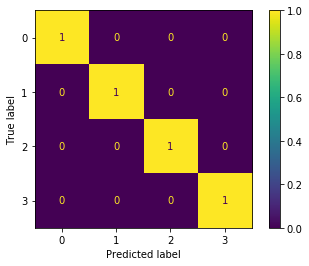

Reward sets:
(0, 0): [-2]
(0, 1): [-3]
(0, 2): [-1, -1]
(0, 3): [-1, -1, 0, 0, -1, 0, 0, -1, -1, 0, -1, 0, -1, 0, 0, 0, 0, -2, -2, -2, 0, 0, -1, -1, 0, -2, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0]
(0, 4): [-1, -1, 0, -3]
(0, 5): [-2]
(0, 6): [-2, -2]
Reward set counts:
Key (0, 0): 1 items
Key (0, 1): 1 items
Key (0, 2): 2 items
Key (0, 3): 38 items
Key (0, 4): 4 items
Key (0, 5): 1 items
Key (0, 6): 2 items


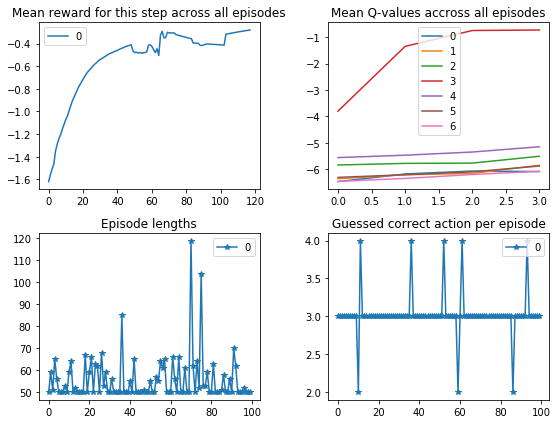

100%|██████████| 100/100 [00:00<00:00, 435.06it/s]


Accuracy: 93.0
Mean episode length: 55.03
Last reward processor:
Estimated confusion matrix:


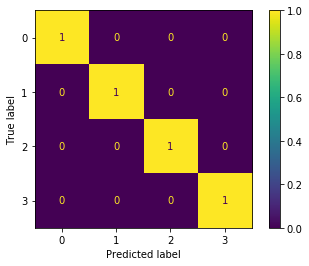

Reward sets:
(0, 0): [-2]
(0, 1): [-2]
(0, 2): [-1, 0, 0, -2, -2]
(0, 3): [-1, 0, 0, 0, -1, 0, 0, 0, 0, -1, 0, 0, -2, -1, 0, 0, 0, -2, -2, -1, 0, -1, 0, -2, -1, -1, 0, 0, 0, 0, -1, 0, 0, 0, 0, -1, 0]
(0, 4): [-1, -1]
(0, 5): [-2]
(0, 6): [-1, -3]
Reward set counts:
Key (0, 0): 1 items
Key (0, 1): 1 items
Key (0, 2): 5 items
Key (0, 3): 37 items
Key (0, 4): 2 items
Key (0, 5): 1 items
Key (0, 6): 2 items


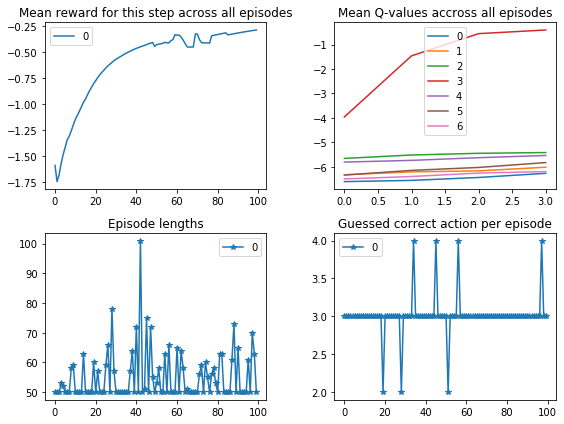

In [18]:
res = {'target': 95.89999999999999, 'params': {'alpha': 0.8236118040381998, 'alpha_decay': 243.0544785033269, 'alpha_min': 0.5113965695937486, 'epsilon': 0.25289603267158034, 'epsilon_decay': 70.53090930872196, 'epsilon_min': 0.044310479986752194, 'gamma': 0.8871072251030447, 'surrogate_c_interval': 67.76179038423699}}
params=res['params']

params['diag'] = 0.99

params['noise'] = True
params['surrogate'] = False
plot_mean_q_values(params=params)

params['surrogate'] = True
plot_mean_q_values(params=params)

# TODO

In [22]:
import numpy as np
from bayes_opt import BayesianOptimization
from pymoo.optimize import minimize
from pymoo.util import plotting
from pymoo.model.problem import Problem

max_steps = 120
num_episodes = 100

class QLearningProblem(Problem):
    def __init__(self):
        super().__init__(n_var=3, n_obj=2, n_constr=0, xl=np.array([0, 0, 10]), xu=np.array([1, 1, 80]))
    
    def _evaluate(self, X, out, *args, **kwargs):
        alpha, epsilon, epsilon_decay = X

        # Run your Q-learning experiment with given parameters
        params = {'alpha': alpha, 'epsilon': epsilon, 'epsilon_decay': epsilon_decay}
        q_values_all_experiments, _, episode_lengths, _, accuracy = qLearningExperiment(adjust_rewards_surrogate, params=params)

        # Maximize accuracy
        out["F"] = [-accuracy, -np.mean(episode_lengths)]

problem = QLearningProblem()

algorithm = minimize(
    algorithm="nsga2",
    problem=problem,
    termination=("n_gen", 20),  # Adjust the number of generations as needed
    save_history=True,
    verbose=True,
)

# Get the best solution from the Pareto front
best_solution = algorithm.result[0]

best_alpha, best_epsilon, best_epsilon_decay = best_solution.X

print(f"Best alpha: {best_alpha}")
print(f"Best epsilon: {best_epsilon}")
print(f"Best epsilon_decay: {best_epsilon_decay}")
print(f"Best accuracy: {-best_solution.F[0]}")
print(f"Best mean_episode_length: {-best_solution.F[1]}")

# You can visualize the Pareto front using pymoo's plotting functions
plotting.plot(obj_space=algorithm.result.F, ideal_point=np.array([0, 0]), title="Pareto Front")


ModuleNotFoundError: No module named 'pymoo'

# Grid search

In [ ]:
from sklearn.model_selection import ParameterGrid

In [ ]:
from IPython import display
import pandas as pd

In [ ]:
max_steps = 120
num_episodes = 20

param_grid = {
    'alpha': [0, 1.0],
    # 'alpha_decay'
    # alpha_min
    'epsilon': [0, 1.0],
    # 'epsilon_decay': [0.1, 1.0],
    # 'gamma'
    'epsilon_decay': [10, 20, 40, 80],
    # 'surrogate_c_interval': [1, 2, 5, 10, 20, 40]
    # 'surrogate_lr'
    }

param_grid_out = pd.DataFrame(ParameterGrid(param_grid))

def get_results_from_grid_row(params):
    q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy = qLearningExperiment(adjust_rewards_surrogate, params=params)
    mean_episode_length = np.mean(episode_lengths)
    print(accuracy, mean_episode_length) 

    return accuracy, mean_episode_length

for i, params in tqdm(param_grid_out.iterrows(), total=param_grid_out.shape[0]):
    accuracy, mean_episode_length = get_results_from_grid_row(params)
    param_grid_out.loc[i, 'accuracy'] = accuracy
    param_grid_out.loc[i, 'mean_episode_length'] = mean_episode_length
    # display.clear_output()

  6%|▋         | 1/16 [00:11<02:47, 11.14s/it]

0.0 121.0


  6%|▋         | 1/16 [00:22<05:40, 22.68s/it]


KeyboardInterrupt: 

In [ ]:
# param_grid_out.iloc[0]['accuracy'] = 1
print(param_grid_out.sort_values(by=['accuracy', 'mean_episode_length'], ascending=False))

    alpha  epsilon  epsilon_decay  accuracy  mean_episode_length
1     0.1      0.1             20      95.0                73.70
7     0.1      1.0             80      90.0                82.70
15    1.0      1.0             80      85.0                91.00
4     0.1      1.0             10      85.0                83.35
10    1.0      0.1             40      85.0                78.55
5     0.1      1.0             20      85.0                75.75
12    1.0      1.0             10      80.0                80.90
6     0.1      1.0             40      75.0                78.45
11    1.0      0.1             80      75.0                78.45
14    1.0      1.0             40      75.0                77.20
8     1.0      0.1             10      75.0                74.95
2     0.1      0.1             40      70.0                87.90
13    1.0      1.0             20      70.0                82.85
3     0.1      0.1             80      65.0                82.65
0     0.1      0.1       

# Epsilon test

# Surrogate rewards without adding noise

In [25]:
from modified_pendulum_processor_noiseless import ModifiedPendulumProcessorNoiseless

In [26]:
post_processor_surrogate = ModifiedPendulumProcessorNoiseless()

def adjust_rewards_surrogate(reward, state, action):    
    observation, reward, done, info = post_processor_surrogate.process_step(state, reward, None, None, action)
    return reward

plot_mean_q_values(adjust_rewards_surrogate)

print(post_processor_surrogate.cmat)
print(post_processor_surrogate.r_sets)
print('Estimated confusion matrix:')
print(np.around(post_processor_surrogate.C, decimals=4))

TypeError: 'NoneType' object cannot be interpreted as an integer